In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from collections import Counter
from sklearn.impute import KNNImputer
import os, gc
import cv2

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [ ]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [ ]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [ ]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import data

In [ ]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

In [ ]:
train_data.shape
test_data.shape

In [ ]:
# keep the relevant columns for the labels in the training data
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()

In [ ]:
x_train = convert_pixels(train_data)
x_test = convert_pixels(test_data)

## EDA  
**train labels**
1. [x] Explore imputation strategies  
    - Completed code. Will require running entire model  
    - Perhaps take a look at images that have missing values to determine if there are inherent reasons why this is not valid.  
    - Create a summary slide of common reasons why things are not labeled.  
2. [ ] Explore outlier correction strategies to identify if areas of the face are mislabeled  
    - Identified several outlier images/labeling that we may be able to throw out of the training dataset
3. [ ] Label as -1,-1 to identify cutoff images  

**train image**  
1. [ ] Add noise via rotation, flipped image, blurring, etc. Ideally, not have to do any of these for capsule networks  
    - contrast
    - rotation
    - flip horizontal
    - blurring
2. [x] Explore imputation strategies  
    - There are no missing pixels in the training or testing images.  
3. [ ] Explore unique images and see if the labels are the same or correct

**test image**. 
1. [x] Review list of images in testing to see if poor quality images can be kept
    - Defined a list of images to definitely throw out

**overall**   
1. [x] Update to RMSE scoring  
2. [ ] Add code to troubleshoot the most wrongly predicted images to identify images causing large sources of error  
  
**Timeline**  
Nov 29: data augmentation  
Dec 6: finish fine tuning + report (ask Doris about final report)  

### Explore NA in labels
Based on the below analysis, distributions are fairly normal with some outliers, and mean and median are fairly similar.

In [ ]:
print('\nNumber of columns with any NA value:')
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()

print('\nNumber of images missing coordinates for each feature:')
train_data[columns_nan].isna().sum(axis=0)

print('\nTest skew of each distribution:')
[(col,['Not normal' if stats.skewtest(train_data[col],nan_policy='omit').pvalue < .05 else 'Normal'][0]) for col in columns_nan]

print('\nCompare mean and median of these distribution:')
train_data.describe().loc[['mean','50%']]
sns.distplot(train_data[columns_nan[0]])
(train_data[columns_nan[0]].mean() - 1.96*train_data[columns_nan[0]].std(), train_data[columns_nan[0]].mean() + 1.96*train_data[columns_nan[0]].std())

Use Nearest Neighbors imputation. Takes closest 3 neighbors with the most important neighbor being the closest neighbor (`weights='distance' vs weights='uniform'`).

In [ ]:
# imputer = KNNImputer(n_neighbors=3, weights='distance')
# y_train = imputer.fit_transform(y_train)

# y_train = y_train.fillna(y_train.mean())
# np.count_nonzero(~np.isnan(y_train))
# y_train = np.nan_to_num(y_train,nan=y_train.mean())


Compare imputed value with the actual image

In [ ]:
def missing_coord(feature:str):
    """
    Compare missing labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing missing feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    missing_feature = train_data.loc[(train_data[x_coord].isnull()) | (train_data[y_coord].isnull()),
                                 [x_coord,y_coord]]
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(missing_feature.index):
        if enum_ind > 10: print('Too many images missing coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')

# missing_coord('right_eye_center')
# missing_coord('left_eye_center')
# missing_coord('mouth_center_top_lip')
# missing_coord('left_eyebrow_outer_end')

### Explore NA in images
There are no missing pixels in the training or testing images.

In [ ]:
img = [set(row.split(' ')) for row in train_data['Image']]
['' in row for row in img].count(True)

In [ ]:
img = [set(row.split(' ')) for row in test_data['Image']]
['' in row for row in img].count(True)

### Explore outliers in labels

In [ ]:
def detect_cutoff(feature:str):
    """
    DEPRECATED
    Compare outlier labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing outlier feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    
    right_bound_y = train_data[y_coord].mean() + 3.5 * train_data[y_coord].std()
    left_bound_y  = train_data[y_coord].mean() - 3.5 * train_data[y_coord].std()    
    
    print(f'\ny coordinate confidence interval: {left_bound_y,right_bound_y}')
    
    outlier_feature = train_data.loc[(train_data[x_coord] <= left_bound_x) | (train_data[x_coord] >= right_bound_x) |
                                     (train_data[y_coord] <= left_bound_y) | (train_data[y_coord] >= right_bound_y),
                                 [x_coord,y_coord]]
    
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(outlier_feature.index):
        if enum_ind > 10: print('Too many images have outlier coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')


In [ ]:
# find eyes that are situated lower than average
left_eye_upper_bound  = train_data['left_eye_center_y'].mean()  + 3 * train_data['left_eye_center_y'].std()
right_eye_upper_bound = train_data['right_eye_center_y'].mean() + 3 * train_data['right_eye_center_y'].std()
mouth_center_top_lip_upper_bound = train_data['mouth_center_top_lip_y'].mean() + 3 * train_data['mouth_center_top_lip_y'].std()

cutoff_faces = train_data[(train_data['left_eye_center_y'] >= left_eye_upper_bound)  |
                          (train_data['right_eye_center_y'] >= right_eye_upper_bound) |
                          (train_data['mouth_center_top_lip_y'] >= mouth_center_top_lip_upper_bound)]

    

Remove these indices from the training dataset:
- 1877
- 1907
- 2199
- 6493

In [ ]:
# for ind in cutoff_faces.index:
#     print('Image Index:',ind)
#     view_img(x_train[ind],get_facial_keypoints(train_data[[col for col in train_data.columns if col != 'Image']].values,ind))
#     view_img(x_train[ind],get_facial_keypoints(y_train,ind))
    

In [ ]:
# remove these indices that are poor labeling and poor image quality
mask = np.ones(x_train.shape[0],dtype=bool)
mask[[1877,1907,2199,6493]] = False
test = x_train[mask,:]

### Explore test images  
- Will need cartoons/drawings of faces
- Will need some cutoff images (missing bottom lip, etc.)
- Will need different ethnicities
- Will need blurred images
- Will need some images with dark lighting
- Will need some images with sun glasses

In [ ]:
# # look at all images in the test set
# for ind in range(x_test.shape[0]):
#     view_img(x_test[ind])

### Explore preprocessing for data

#### Flip images horizontally

In [ ]:
def flip_img_horiz():
    """
    Flip images horizontally for all training images
    """
    # Flip images
    flip_img = np.array([np.fliplr(x_train[[ind]][0]) for ind in range(x_train.shape[0])])
    
    # Flip x coordinates
    flip_train_data = train_data.copy()
    x_columns = [col for col in flip_train_data.columns if '_x' in col]
    flip_train_data[x_columns] = flip_train_data[x_columns].applymap(lambda x: 96-x)

    # Flip left and right values
    real_left_val = flip_train_data[[col for col in flip_train_data if 'right_' in col]]
    real_right_val = flip_train_data[[col for col in flip_train_data if 'left_' in col]]
    flip_train_data[[col for col in flip_train_data if 'right_' in col]] = real_right_val
    flip_train_data[[col for col in flip_train_data if 'left_' in col]] = real_left_val
    
    # Output in correct format
    flip_coord = flip_train_data[[col for col in flip_train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

flipped_img,flipped_coord = flip_img_horiz()

view_img(x_train[[5]],coord=get_facial_keypoints(y_train,5))
view_img(flipped_img[[5]],coord=get_facial_keypoints(y_train,5))
view_img(flipped_img[[5]],coord=get_facial_keypoints(flipped_coord,5))

# add to training array
x_train.shape
y_train.shape
# x_train = np.append(x_train,flipped_img,axis=0)
# y_train = np.append(y_train,flipped_coord,axis=0)
x_train.shape
y_train.shape

compare_coord = train_data.iloc[[5]].T.copy().iloc[:-1]
compare_coord['flipped'] = flipped_coord[[5]].T

compare_coord

#### Add blurring to the images

In [ ]:
view_img(x_train[[5]])
view_img(cv2.GaussianBlur(x_train[[5]][0],(5,5),0))
view_img(cv2.GaussianBlur(x_train[[5]][0],(5,5),2),coord=get_facial_keypoints(y_train,5))

blurr_img = np.array([cv2.GaussianBlur(x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(x_train.shape[0])])
blurr_img.shape
x_train.shape
# x_train = np.append(x_train,blurr_img)
# y_train = np.append(y_train,y_train,axis=0)

In [ ]:
rows,cols = (96,96)

M = cv2.getRotationMatrix2D((cols/2,rows/2),45,1)
dst = cv2.warpAffine(x_train[[5]].reshape(96,96,1),M,(cols,rows))

#TODO get random rotation (-15,15) degrees
view_img(dst)

#### Add contrast to the images

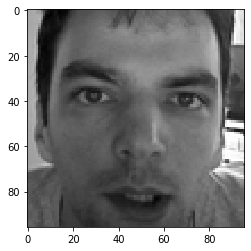

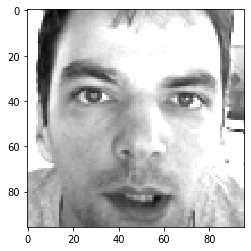

In [155]:
brightness = .5
view_img(x_train[[5]])
example = x_train[[5]]+brightness
example[example > 1] = 1
view_img(example)


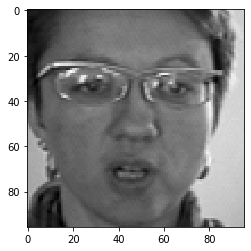

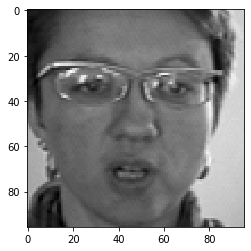

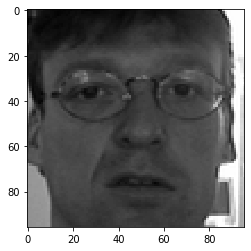

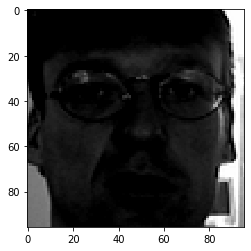

In [167]:
# apply brightness randomly
brightness = np.random.choice(np.round(np.arange(-.3,.8,.1),2),size=x_train.shape[0])
bright_img = np.array([x_train[[ind]][0]+brightness[ind] for ind in range(x_train.shape[0])])
bright_img[bright_img > 1] = 1
bright_img[bright_img < 0] = 0
view_img(x_train[[10]])
view_img(bright_img[[10]])
view_img(x_train[[15]])
view_img(bright_img[[15]])